# Install and Import Required Libraries

Install FSL and import necessary libraries such as nibabel and subprocess.


In [1]:
%pip install tensorflow nibabel dicom2nifti nilearn matplotlib numpy

  Using cached tensorflow-2.18.0-cp310-cp310-macosx_12_0_arm64.whl.metadata (4.0 kB)
  Using cached nibabel-5.3.2-py3-none-any.whl.metadata (9.1 kB)
  Using cached dicom2nifti-2.5.1-py3-none-any.whl.metadata (1.3 kB)
  Using cached nilearn-0.11.1-py3-none-any.whl.metadata (9.3 kB)
  Using cached matplotlib-3.10.0-cp310-cp310-macosx_11_0_arm64.whl.metadata (11 kB)
  Using cached numpy-2.2.3-cp310-cp310-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-1-py2.py3-none-macosx_11_0_arm64.whl.metadata (5.2 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-5.29.3-cp38-abi3-macosx_10_9_unive

In [1]:
import os
import time
import dicom2nifti
import subprocess
import nibabel as nib
import numpy as np
import nilearn.plotting as plotting
import matplotlib.pyplot as plt

# Set the base directory
DATA = "./ADNI_SS_copy"

# Convert dicom to NII


In [ ]:
def convert_dicom_to_nifti(base_dir):
    """Converts DICOM files to NIfTI while preserving folder structure."""
    for root, dirs, files in os.walk(base_dir):
        if any(f.endswith(".dcm") for f in files):
            nii_output_dir = root  # Save in the same directory as DICOMs
            nii_output_path = os.path.join(nii_output_dir, "scan.nii.gz")

            if not os.path.exists(nii_output_path):  # Avoid redundant conversion
                try:
                    dicom2nifti.convert_directory(
                        root, nii_output_dir, compression=True, reorient=True
                    )
                    print(f"Converted: {root} -> {nii_output_path}")

                    # Remove DICOM files after conversion
                    for file in files:
                        os.remove(os.path.join(root, file))
                except Exception as e:
                    print(f"Failed to convert {root}: {e}")


convert_dicom_to_nifti(DATA)

# Skull Stripping

There is a linear example below but you should run the parallel script instead


In [2]:
def run_synthstrip(freesurfer_home, input_path, ss_output_path):
    """Runs SynthStrip on a single NIfTI file."""
    if os.path.exists(ss_output_path):  # Avoid redundant processing
        print(f"Skipping {input_path}, output already exists.")
        return

    try:
        env = os.environ.copy()
        env["FREESURFER_HOME"] = freesurfer_home
        env["SUBJECTS_DIR"] = os.path.join(freesurfer_home, "subjects")

        command = [
            "/bin/bash",
            "-c",  # Use bash explicitly
            f"source {freesurfer_home}/SetUpFreeSurfer.sh && "
            f"mri_synthstrip -i {input_path} -o {ss_output_path}",
        ]

        start_time = time.time()
        subprocess.run(command, check=True, env=env)
        elapsed_time = time.time() - start_time

        print(
            f"✔ Processed: {input_path} -> {ss_output_path} (Time: {elapsed_time:.2f}s)"
        )

        # Remove original unstripped file
        os.remove(input_path)

    except subprocess.CalledProcessError as e:
        print(f"❌ Failed to process {input_path}: {e}")


def skull_strip_nifti(base_dir, freesurfer_home="/Applications/freesurfer/7.4.1"):
    """Runs SynthStrip on NIfTI files sequentially while preserving folder structure."""
    tasks = []

    for root, _, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".nii.gz") and not file.startswith("ss_"):
                input_path = os.path.join(root, file)
                ss_output_path = os.path.join(root, "ss_" + file)
                tasks.append((freesurfer_home, input_path, ss_output_path))

    total_tasks = len(tasks)
    if total_tasks == 0:
        print("✅ No new NIfTI files to process.")
        return

    print(f"🔍 Found {total_tasks} files to process.")

    start_time = time.time()

    # Process tasks sequentially
    for i, task in enumerate(tasks):
        print(f"[{i+1}/{total_tasks}] Processing: {task[1]}")
        try:
            run_synthstrip(*task)
        except Exception as e:
            print(f"⚠️ Error processing {task[1]}: {e}")

    elapsed_time = time.time() - start_time
    print(f"✅ Finished processing all files in {elapsed_time:.2f}s.")


skull_strip_nifti(DATA)

🔍 Found 851 files to process.
[1/851] Processing: ./ADNI_SS_copy/062_S_0690/MPRAGE/2007-01-29_16_15_42.0/I37639/4_mprage.nii.gz
Skipping ./ADNI_SS_copy/062_S_0690/MPRAGE/2007-01-29_16_15_42.0/I37639/4_mprage.nii.gz, output already exists.
[2/851] Processing: ./ADNI_SS_copy/062_S_0690/MPRAGE/2006-07-18_10_19_47.0/I19123/3_mprage.nii.gz
Skipping ./ADNI_SS_copy/062_S_0690/MPRAGE/2006-07-18_10_19_47.0/I19123/3_mprage.nii.gz, output already exists.
[3/851] Processing: ./ADNI_SS_copy/062_S_0690/MPRAGE/2007-07-31_09_21_42.0/I63347/3_mprage.nii.gz
Skipping ./ADNI_SS_copy/062_S_0690/MPRAGE/2007-07-31_09_21_42.0/I63347/3_mprage.nii.gz, output already exists.
[4/851] Processing: ./ADNI_SS_copy/062_S_0690/MPRAGE/2008-07-29_10_46_39.0/I114599/3_mprage.nii.gz
Skipping ./ADNI_SS_copy/062_S_0690/MPRAGE/2008-07-29_10_46_39.0/I114599/3_mprage.nii.gz, output already exists.
[5/851] Processing: ./ADNI_SS_copy/013_S_0699/MPRAGE/2006-08-28_15_00_26.0/I23534/2_mprage.nii.gz
Skipping ./ADNI_SS_copy/013_S_0699

KeyboardInterrupt: 

Traceback (most recent call last):
  File "/Applications/freesurfer/7.4.1/python/scripts/mri_synthstrip", line 237, in <module>
    sdt = model(input_tensor).cpu().numpy().squeeze()
  File "/Applications/freesurfer/7.4.1/python/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Applications/freesurfer/7.4.1/python/scripts/mri_synthstrip", line 157, in forward
    x = conv(x)
  File "/Applications/freesurfer/7.4.1/python/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Applications/freesurfer/7.4.1/python/scripts/mri_synthstrip", line 186, in forward
    out = self.conv(x)
  File "/Applications/freesurfer/7.4.1/python/lib/python3.8/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/Applications/freesurfer/7.4.1/python/lib/python3.8/site-packages/torch/nn/modul

# Visualise the Stripped Scans


In [ ]:
# List all NIfTI files
def get_nifti_files(base_dir):
    """Retrieve all NIfTI file paths in the directory."""
    nii_files = []
    non_ss_nii_files = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith(".nii.gz"):
                if file.startswith("ss_"):
                    nii_files.append(os.path.join(root, file))
                else:
                    non_ss_nii_files.append(os.path.join(root, file))
    return nii_files, non_ss_nii_files


nii_files, non_ss_nii_files = get_nifti_files(DATA)

# Display the number of NIfTI files found
print(f"Total number of NIfTI files found: {len(nii_files)}")
print(f"Total number of non-ss NIfTI files found: {len(non_ss_nii_files)}")

# Display the first few NIfTI file paths
print("First few NIfTI files:")
for file in nii_files[:5]:
    print(file)

# Visualize all NIfTI scans
for scan in nii_files[::50]:
    img = nib.load(scan)
    plotting.plot_anat(
        img,
        title=f"Anatomical View: {scan}",
        annotate=False,
        draw_cross=False,
        cut_coords=(0, 0, 0),
    )
    plt.show()

# Compare Skull Stripped to OG

Load the original MRI scan and stripped one for comparison


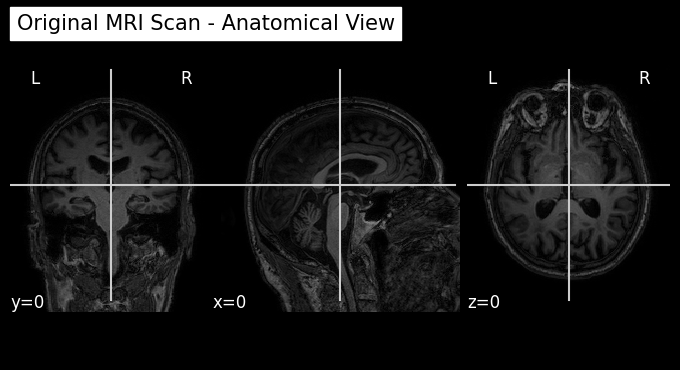

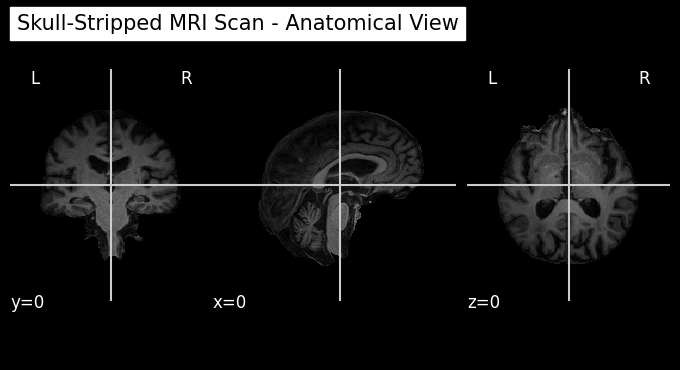

In [11]:
# Define the path to the original and skull-stripped MRI scan files
original_mri_scan_path = (
    "ADNI_NII/002_S_0559/MPRAGE/2009-06-30_17_01_28.0/I147119/301_mprage.nii.gz"
)
skull_stripped_mri_scan_path = "ADNI_NII_stripping/002_S_0559/MPRAGE/2009-06-30_17_01_28.0/I147119/ss_301_mprage.nii.gz"

# Load the original MRI scan using nibabel
original_mri_scan = nib.load(original_mri_scan_path)

# Load the skull-stripped MRI scan using nibabel
skull_stripped_mri_scan = nib.load(skull_stripped_mri_scan_path)

# Visualize the original MRI scan
plotting.plot_anat(
    original_mri_scan, title="Original MRI Scan - Anatomical View", cut_coords=(0, 0, 0)
)
plt.show()

# Visualize the skull-stripped MRI scan
plotting.plot_anat(
    skull_stripped_mri_scan,
    title="Skull-Stripped MRI Scan - Anatomical View",
    cut_coords=(0, 0, 0),
)
plt.show()

# Bias Field Correction

Use FSL's FAST (FMRIB's Automated Segmentation Tool) for bias field correction.


Bias field corrected MRI scan data shape: (170, 256, 256)


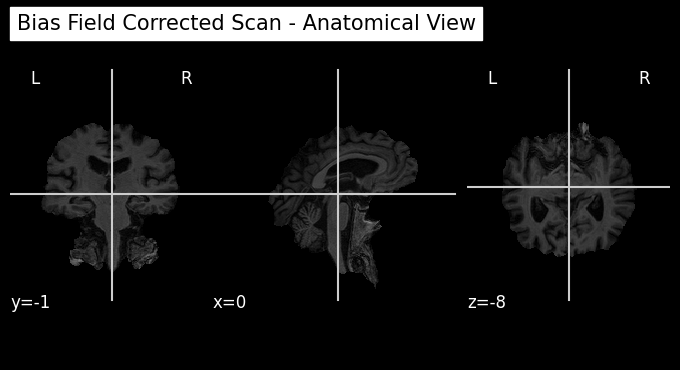

In [ ]:
# Bias Field Correction

# Define the output path for the bias field corrected MRI scan
bias_corrected_output_path = "bias_corrected_mri_scan.nii.gz"

# Use FSL's FAST (FMRIB's Automated Segmentation Tool) for bias field correction
# subprocess.run(['fast', '-B', '-o', bias_corrected_output_path, skull_stripped_output_path])

# Load the bias field corrected MRI scan using nibabel
bias_corrected_mri_scan = nib.load(bias_corrected_output_path[:-7] + "_restore.nii.gz")

# Get the data from the bias field corrected MRI scan
bias_corrected_mri_scan_data = bias_corrected_mri_scan.get_fdata()

# Display the shape of the bias field corrected MRI scan data
print("Bias field corrected MRI scan data shape:", bias_corrected_mri_scan_data.shape)

# Visualize the bias field corrected scan
plotting.plot_anat(
    bias_corrected_mri_scan, title="Bias Field Corrected Scan - Anatomical View"
)
plt.show()

# Resampling

Use FSL's FLIRT (FMRIB's Linear Image Registration Tool) for resampling the MRI scan.
